In [14]:
import math
import torch.nn as nn

class Crack(nn.Module):
    def __init__(self, Crack_cfg):
        super(Crack, self).__init__()
        self.features = self._make_layers(Crack_cfg)
        self.linear1 = nn.Linear(32*6*6,64)
        self.linear2 = nn.Linear(64,64)
        self.linear3 = nn.Linear(64,2)


    def forward(self, x):
        out = self.features(x)
#         print(out.size())
        out = out.view(out.size(0), -1)
        out = self.linear1(out)
        out = self.linear2(out)
        out = self.linear3(out)
        return out

    def _make_layers(self, cfg):
        """
        cfg: a list define layers this layer contains
            'M': MaxPool, number: Conv2d(out_channels=number) -> BN -> ReLU
        """
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
            
#         layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [15]:
Crack_cfg = {
    'Crack11':[16,16,'M',32,32,'M']
}

model_t = Crack(Crack_cfg['Crack11']);

In [16]:
from functools import partial
import pickle
import torch
# pickle.load = partial(pickle.load, encoding="latin1")
# pickle.Unpickler = partial(pickle.Unpickler, encoding="latin1")
# model = torch.load('D:\\大三下\\人工神经网络\\crack.pt', map_location=lambda storage, loc: storage, pickle_module=pickle)


# model = torch.load('D:/大三下/人工神经网络/best.pt')
model = torch.load('./crack0.9373REC_0.9331.pt')
model_t.load_state_dict(model)

model_t.eval()
device = "cpu"

In [17]:


"""
 1.需要将图片reshape成,长和宽都是27的倍数
 2.切割图片
 3.将这批图片处理成4元tuple，正则化到[-1,1]区间
 4.将图片用模型检验
 5.print实验结果 
 6.将tensor转换成图片
"""


import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2
from torch.autograd import Variable

from skimage import io, transform
from torchvision import transforms, utils

test_trainsforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

def classify(img):
    # 切分为imgNum^2份
    width_num = img.shape[0]//(27)    
    print(width_num)
    height_num = img.shape[1]//(27)
    print(height_num)
    # 分割图片
    img_roi = []
    for i in range(width_num):  # [1]480*360==15*11---height
        for j in range(height_num):  # [2]column-----------width
            img_roi.append(img[(i * 27):((i + 1) * 27), (j * 27):((j + 1) * 27)])

    # 转换图片并开始识别
    t = img_roi[0]
    t = to_pil(t)
    t = test_trainsforms(t).float()
    t = t.unsqueeze_(0)
    # print(t.size())
    for i in range(len(img_roi)):
        if i != 0 :
            te = img_roi[i]
            te = to_pil(te)
            te = test_trainsforms(te).float()
            te = te.unsqueeze_(0)
            t = torch.cat((t,te),0)
            # print(t.size())
    return predict_img(t)

def classify_v2(img):
    #对像素逐一采样并输出，会迭代（480-27）*（320-27）次
    width = img.shape[0]
    height = img.shape[1]
    arr = []
    for i in range(14,width-13):
        for j in range(14,height-13):
#             if(i-14 > 0 and i + 13 < width and j - 14 > 0 and j + 13 < height):
            t = img[i-14:i+13,j-14:j+13]
            t = to_pil(t)
            t = test_trainsforms(t).float()
            t = t.unsqueeze_(0)
            temp = predict_img(t)
#                 print(np.array(temp).shape)
#                 if(i % 27 == 0):
#                 print(temp)
            arr.append(temp)
        if(i % 100 == 0):
            print(i)
    return arr
# 	# print(st)
# 	# 对目标进行定位
# 	loc = []
# 	for i in st:
# 	    x = i % imgNum
# 	    y = i // imgNum
# 	    loc.append([x,y])
# 	# print(loc)
# 	# 在图片上标记目标
# 	for i in loc:
# 	    cv2.rectangle(img, (i[0]*imw,i[1]*imh), (i[0]*imw+imw,i[1]*imh+imh), (255,0,0), 3)
# 	# cv2.rectangle(img, 左上角, 右下角, （r，g，b）, 粗细（1，2，3，，）)
# 	# 返回已画好的图片
# 	return img 

In [18]:
def predict_img(inputs):
    with torch.no_grad():
        inputs = inputs.to(device)
        outputs = model_t(inputs)
        imgNum = inputs.size()[0]
        _,preds = torch.max(outputs,1)
        std = []
#         print(preds)
        return preds
#         for j in range(inputs.size()[0]):
#             # ax = plt.subplot(imgNum//2,2,j+1)
#             # ax.axis('off')
#             # ax.set_title('predicted: {}'.format(classname[preds[j]]))
#             if preds[j] == 0:
#                 std.append(j)
#             # imshow(inputs.cpu().data[j])
#         return std

In [19]:
to_pil = transforms.ToPILImage()

In [20]:
def imshow(inp):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5,0.5,0.5])
    std = np.array([0.5,0.5,0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)  # pause a bit so that plots are updated


In [21]:
#-*-coding:utf-8-*-
import torch
from torchvision import transforms
from PIL import Image
import cv2

# path = "./image/"
path = "I:/1裂缝检测/CrackForest-dataset/image/"
savePath = "./img/"

# file_list = os.listdir(path)
# img_list = [file_name for file_name in file_list if file_name.endswith(".jpg")]
# print("find mat file : ", img_list)
    

# file = "I:/1裂缝检测/CrackForest-dataset/image/090.jpg"
for i in range(56,72):
    img_name = "{:0>3d}.jpg".format(i)
    print(img_name)
    img = io.imread(path + img_name)
    img2 = cv2.copyMakeBorder(img,14,13,14,13,cv2.BORDER_ISOLATED)
    inp = classify_v2(img2)
    temp = np.array(inp)
    temp.resize(320,480)
    temp = temp * 256
    cv2.imwrite(savePath + img_name,temp)
#     break

056.jpg
100
200
300
057.jpg
100
200
300
058.jpg
100
200
300
059.jpg
100
200
300
060.jpg
100
200
300
061.jpg
100
200
300
062.jpg
100
200
300
063.jpg
100
200
300
064.jpg
100
200
300
065.jpg
100
200
300
066.jpg
100
200
300
067.jpg
100
200
300
068.jpg
100
200
300
069.jpg
100
200
300
070.jpg
100
200
300
071.jpg
100
200
300


resize该矩阵

In [ ]:
temp = np.array(inp)
temp.resize(320,480)

保存灰度图

In [ ]:
temp = temp * 256
cv2.imwrite("./22.jpg",temp)

显示灰度图

In [ ]:
plt.imshow(temp, cmap=plt.cm.gray, interpolation='nearest')

显示原图

In [ ]:
img = io.imread(file)
temp = np.array(img)
plt.imshow(temp, cmap=plt.cm.gray, interpolation='nearest')

# 组合图片

In [23]:
from PIL import Image
# 图片组合
predit_img_path = "./img/"
origion_img_path = "I:/1裂缝检测/CrackForest-dataset/image/"
combined_img_path = "./img_combine/"


for i in range(73,101):
    img_name = "{:0>3d}.jpg".format(i)
    predit_img = Image.open(predit_img_path+img_name)
    origion_img = Image.open(origion_img_path+img_name)
    target = Image.new('RGB',(480*2+20,320))
    target.paste(predit_img,(0,0,480,320))
    target.paste(origion_img,(490,0,970,320))
    target.save(combined_img_path+img_name)
#     break

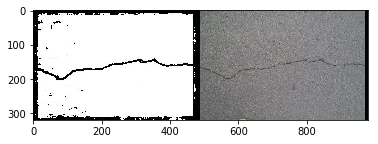

In [12]:
img = io.imread("./img_combine/001.jpg")
temp = np.array(img)
plt.imshow(temp, cmap=plt.cm.gray, interpolation='nearest')